## Import Modules

In [15]:
import torch
import torch.nn.functional as F

import numpy as np
import json
import torchvision.transforms as transforms

from IPython.display import HTML, display
import tabulate

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import skimage.transform
import argparse

from scipy.misc import imread, imresize
from PIL import Image

from utils.url import is_absolute_path, read_image_from_url

import warnings
warnings.filterwarnings('ignore')

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Functions

In [17]:
def encode_tags(encoder_tagger, image_path):
    r"""Reads an image and captions it with beam search.

    Arguments
        encoder: encoder model
        decoder: decoder model
        image_path: path to image
        word_map: word map
        beam_size: number of sequences to consider at each decode-step
    Return
        String : caption
        Float  : weights for visualization
    """

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img).to(device)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    tag_out = encoder_tagger(image)

    return tag_out

<br />

## Caption Generation

### Load Model

In [20]:
models = [
    {
        'name': 'coco_en',
        'tagger_path': './pretrained/en/coco/BEST_checkpoint_tagger_coco_5_cap_per_img_5_min_word_freq.pth.tar',
        'tag_map_path': './scn_data/en/coco/TAGMAP_coco_5_cap_per_img_5_min_word_freq.json'
    },
    {
        'name': 'flickr30k',
        'tagger_path': './pretrained/en/flickr30k/BEST_checkpoint_tagger_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar',
        'tag_map_path': './scn_data/en/flickr30k/TAGMAP_flickr30k_5_cap_per_img_5_min_word_freq.json'
    },
    {
        'name': 'flickr10k',
        'tagger_path': './pretrained/id/prosa-flickr10k/BEST_checkpoint_tagger_flickr10k_5_cap_per_img_5_min_word_freq.pth.tar',
        'tag_map_path': './scn_data/id/prosa-flickr10k/TAGMAP_flickr10k_5_cap_per_img_5_min_word_freq.json'
    },
    {
        'name': 'flickr8k',
        'tagger_path': './pretrained/id/flickr8k/BEST_checkpoint_tagger_flickr8k_id_5_cap_per_img_5_min_word_freq.pth.tar',
        'tag_map_path': './scn_data/id/flickr8k/TAGMAP_flickr8k_id_5_cap_per_img_5_min_word_freq.json'
    },
    {
        'name': 'coco_id',
        'tagger_path': './pretrained/id/coco/BEST_checkpoint_tagger_coco_id_5_cap_per_img_5_min_word_freq.pth.tar',
        'tag_map_path': './scn_data/id/coco/TAGMAP_coco_id_5_cap_per_img_5_min_word_freq.json'
    }
]

#### Tagger Model

In [21]:
%%capture
for model in models:
    tagger_checkpoint = torch.load(
        model['tagger_path'], map_location=lambda storage, loc: storage)
    model['tagger'] = tagger_checkpoint['encoder']
    model['tagger'] = model['tagger'].to(device)
    model['tagger'].eval()
    
    with open(model['tag_map_path'], 'r') as j:
        tag_map = json.load(j)
    rev_tag_map = {v: k for k, v in tag_map.items()}
    
    model['tag_map'] = tag_map
    model['rev_tag_map'] = rev_tag_map

### Variables

In [22]:
file_img_path = './figures/390337415_aebcb3a061_z.jpg'
tag_out_count = 10
beam_size = 5
smooth = True

In [23]:
file_img = file_img_path
if is_absolute_path(file_img_path):
    file_img = read_image_from_url(file_img_path)

<br />

### Show Image

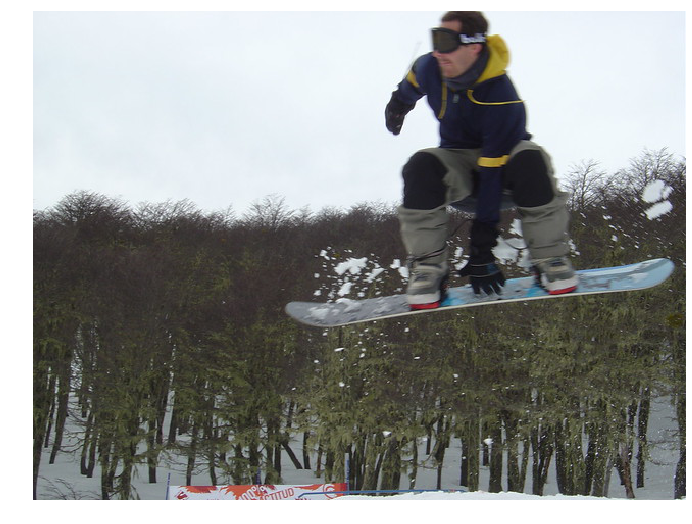

In [24]:
fig, ax = plt.subplots(figsize=(18,9))
img = imread(file_img)
plt.axis('off')
ax.imshow(img)

<br />

### Decode Tags

In [27]:
for model in models:
    tags = encode_tags(model['tagger'], file_img).flatten().tolist()
    tags_out_index = np.argsort(tags)[-tag_out_count:]
    
    print(model['name'])
    for idx in tags_out_index:
        print('{} ({:.4f})'.format(model['rev_tag_map'][idx], tags[idx]))
    print()

coco_en
ski (0.3643)
snowboarder (0.4001)
trick (0.4068)
person (0.4104)
snowboard (0.4121)
jump (0.4135)
jumping (0.4200)
air (0.4349)
man (0.4611)
snow (0.8923)

flickr30k
yellow (0.2360)
race (0.2847)
trick (0.3097)
man (0.3311)
midair (0.3809)
wearing (0.4154)
jump (0.4581)
air (0.5122)
jumping (0.5274)
snow (0.5694)

flickr10k
kendara (0.2799)
luncur (0.3177)
kuning (0.3459)
dalam (0.3593)
atas (0.3598)
lompat (0.3781)
pria (0.3982)
main (0.4308)
salju (0.5742)
orang (0.9260)

flickr8k
ski (0.2134)
udara (0.2189)
papan (0.2323)
orang (0.2474)
dalam (0.3227)
anak (0.3417)
merah (0.3483)
salju (0.4129)
pria (0.4648)
atas (0.4750)

coco_id
kendara (0.4519)
laku (0.5829)
pria (0.5879)
trik (0.6241)
main (0.7240)
lompat (0.7615)
ski (0.8117)
papan (0.8754)
orang (0.9660)
salju (0.9721)



<br />